In [183]:
''' 1. Zipcodes to ZCTAs mapping
This script maps every US zipcode to its corresponding ZCTA as mapped
by US Bureau of Statistics

2. Socio-economic classification of Zipcodes/ZCTAs
using K-Means Clustering Algorithm by household income
''' 
# Authour Diana Kung'u

from pandas import read_csv, merge, read_excel, ExcelFile, concat
import numpy as np

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
import  squarify # Treemap

In [184]:
#Read Data
zctas = read_csv('.\Input\ZCTA_Household_income.csv')

with ExcelFile(r'.\Input\ZiptoZcta_Crosswalk_2021.xlsx') as xl :
    df = concat([read_excel(xl, sheet_name = s ) for s in xl.sheet_names],
                ignore_index= True)


In [185]:
df.ZCTA = df.ZCTA.astype('str')

print(f'df.ZIP_CODE dtype: {df.ZIP_CODE.dtype}, with {df.ZIP_CODE.nunique()} unique values.')
print(f'df.ZCTA dtype: {df.ZCTA.dtype}, with {df.ZCTA.nunique()} unique values.')

df.ZIP_CODE dtype: int64, with 41107 unique values.
df.ZCTA dtype: object, with 33144 unique values.


In [186]:
#Check the length of ZCTA codes
df['len'] = df.ZCTA.str.len()
df['len'].unique() # There are  5, nan and 7 length codes
df[df['len'] == 7] # This represent 'No ZCTA' drop	
df.drop(df[df['len'] == 7].index, inplace= True)

df.ZCTA = [c if len(c) == 5 else '0'+ c if len(c) == 4 else '00'+c 
             for c in df.ZCTA]

In [187]:
print(f'df.ZIP_CODE dtype: {df.ZIP_CODE.dtype}, with {df.ZIP_CODE.nunique()} unique values.')
print(f'df.ZCTA dtype: {df.ZCTA.dtype}, with {df.ZCTA.nunique()} unique values.')

df.ZIP_CODE dtype: int64, with 41099 unique values.
df.ZCTA dtype: object, with 33139 unique values.


In [188]:
zctas.ZCTA = zctas.ZCTA.astype('str')
print(f'ZCTA dtype: {zctas.ZCTA.dtype} with {zctas.ZCTA.nunique()} unique values')

# Convert all ZCTAs to 5 digit
zctas.ZCTA = [c if len(c) == 5 else '0'+ c if len(c) == 4 else '00'+c 
             for c in zctas.ZCTA]


ZCTA dtype: object with 33120 unique values


In [189]:
df = df.iloc[:, [0,2,4]].copy()
df = df.drop_duplicates(keep='last')

df = df.merge(zctas, how='right', left_on= 'ZCTA', right_on= 'ZCTA')


In [190]:
#convert zip_codes to 5-digit str object
df.ZIP_CODE = df.ZIP_CODE.astype('Int64') 
df.drop(df[df.ZIP_CODE.isna()].index, inplace= True) # drop rows with missing zipcodes
df.ZIP_CODE = df.ZIP_CODE.astype('str')
df.ZIP_CODE = [c if len(c) == 5 else '0'+ c if len(c) == 4 else '00'+c 
             for c in df.ZIP_CODE]
df.head()

,ZIP_CODE,STATE,ZCTA,Households100to149K,Households150to199K,Households200KorMore,RFM1,RFM2,RFM3
0,35007,AL,35007,2224,473,254,9,8,7
1,35137,AL,35007,2224,473,254,9,8,7
2,35144,AL,35007,2224,473,254,9,8,7
3,35124,AL,35124,2012,809,805,9,8,8
4,35173,AL,35173,2265,1037,980,9,9,9


In [191]:
df['RFM_Score'] = df[['RFM1', 'RFM2', 'RFM3']].sum(axis = 1)
df['RFM_Group'] = df['RFM1'].map(str) + df['RFM2'].map(str) + df['RFM3'].map(str)
df.head()

,ZIP_CODE,STATE,ZCTA,Households100to149K,Households150to199K,Households200KorMore,RFM1,RFM2,RFM3,RFM_Score,RFM_Group
0,35007,AL,35007,2224,473,254,9,8,7,24,987
1,35137,AL,35007,2224,473,254,9,8,7,24,987
2,35144,AL,35007,2224,473,254,9,8,7,24,987
3,35124,AL,35124,2012,809,805,9,8,8,25,988
4,35173,AL,35173,2265,1037,980,9,9,9,27,999


(array([ 7271.,  3042.,  3799.,  3492.,  3743.,  4123.,  4780., 10816.]),
 array([0.   , 1.125, 2.25 , 3.375, 4.5  , 5.625, 6.75 , 7.875, 9.   ]),
 <BarContainer object of 8 artists>)

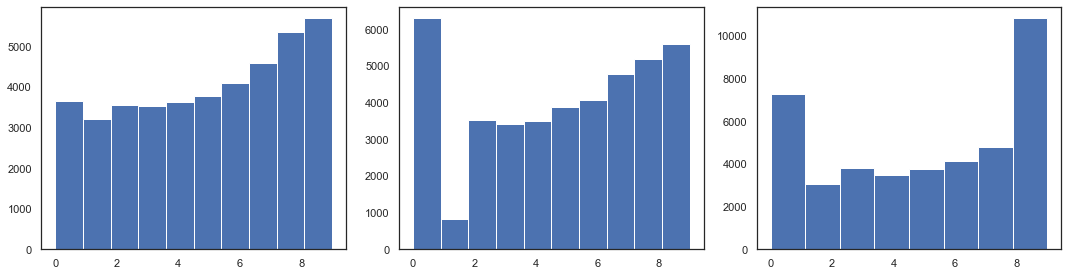

In [192]:
#Distribution of RFM 1, RFM 2 and RFM 3
figure, axs = plt.subplots(1, 3,figsize=(15, 4), facecolor='w', edgecolor='k',
                             tight_layout=True)

axs[0].hist(df.RFM1, bins=10)
axs[1].hist(df.RFM2, bins=10)
axs[2].hist(df.RFM3, bins=8)



In [193]:
#Check the skew
df.skew()

c:\Users\DIANA\Desktop\E-commerce-RFM-Analysis\rfm\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


ZIP_CODE                0.069315
ZCTA                    0.070028
Households100to149K     2.018696
Households150to199K     2.743939
Households200KorMore    4.431109
RFM1                   -0.222285
RFM2                   -0.271716
RFM3                   -0.291696
RFM_Score              -0.189622
RFM_Group              -0.211253
dtype: float64

(array([ 7271.,  3042.,  3799.,  3492.,  3743.,  4123.,  4780., 10816.]),
 array([0.   , 1.125, 2.25 , 3.375, 4.5  , 5.625, 6.75 , 7.875, 9.   ]),
 <BarContainer object of 8 artists>)

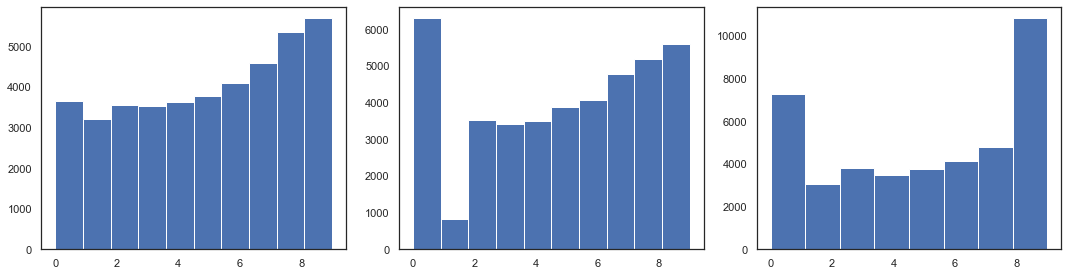

In [194]:
#Perform Log transformation to bring data into normal or near normal distribution
log_Tfd_Data = df[['RFM1', 'RFM2', 'RFM3']].apply(lambda x : np.log(x+1), axis = 1).round(3)

x = df[['RFM1', 'RFM2', 'RFM3']]
figure, axs = plt.subplots(1, 3,figsize=(15, 4), facecolor='w', edgecolor='k',
                             tight_layout=True)

axs[0].hist(x.RFM1, bins=10)
axs[1].hist(x.RFM2, bins=10)
axs[2].hist(x.RFM3, bins=8)


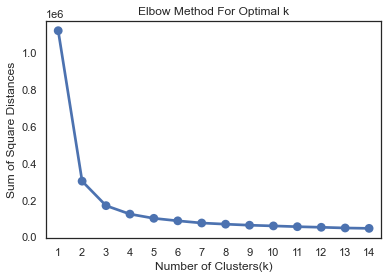

In [195]:


sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 10000)
    km = km.fit(x)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [196]:
#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 5, init= 'k-means++', max_iter= 10000)
KMean_clust.fit(x)

#Find the clusters for the observation given in the dataset
df['Cluster'] = KMean_clust.labels_
df.head()

,ZIP_CODE,STATE,ZCTA,Households100to149K,Households150to199K,Households200KorMore,RFM1,RFM2,RFM3,RFM_Score,RFM_Group,Cluster
0,35007,AL,35007,2224,473,254,9,8,7,24,987,0
1,35137,AL,35007,2224,473,254,9,8,7,24,987,0
2,35144,AL,35007,2224,473,254,9,8,7,24,987,0
3,35124,AL,35124,2012,809,805,9,8,8,25,988,0
4,35173,AL,35173,2265,1037,980,9,9,9,27,999,0


In [197]:
#Map clusters to status labels
class_dict = {0: 'upper', 1: 'upper_middle', 2: 'middle', 3: 'working', 4: 'lower'}
df['Status'] = df.Cluster.map(class_dict)
df.head()

,ZIP_CODE,STATE,ZCTA,Households100to149K,Households150to199K,Households200KorMore,RFM1,RFM2,RFM3,RFM_Score,RFM_Group,Cluster,Status
0,35007,AL,35007,2224,473,254,9,8,7,24,987,0,upper
1,35137,AL,35007,2224,473,254,9,8,7,24,987,0,upper
2,35144,AL,35007,2224,473,254,9,8,7,24,987,0,upper
3,35124,AL,35124,2012,809,805,9,8,8,25,988,0,upper
4,35173,AL,35173,2265,1037,980,9,9,9,27,999,0,upper


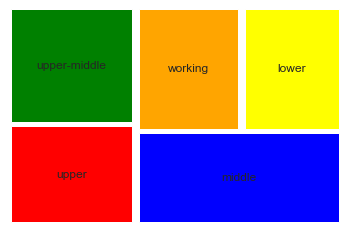

Status
lower            7215
middle           8494
upper           10830
upper_middle     7489
working          7038
Name: Cluster, dtype: int64

In [198]:
#Treemap: Distribution of clusters
labels = ['upper', 'upper-middle', 'middle', 'working', 'lower']
color = ['red', 'green', 'blue', 'orange', 'yellow']
df_classes = df.groupby('Status')['Cluster'].count()

squarify.plot(df_classes.values,
              color=color, label= labels, pad = True)
plt.axis('off')
plt.show()
df_classes